In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import contextily as ctx

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patheffects import withStroke
import matplotlib.patches as mpatches  # Pour créer des carrés dans la légende


c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Lecture des donées

In [2]:
## Lecture des données
salle_file = 'educ_salles_etablissement_scolaire'
bati_file = 'educ_batiments_etablissement_scolaire'
etab_file = 'educ_etablissements_scolaires'
classe_file = 'educ_classes_etablissement_scolaire'

bati = gpd.read_file(os.path.join('.','data',bati_file+'.gpkg'))
salles = gpd.read_file(os.path.join('.','data',salle_file+'.gpkg'))
etab = gpd.read_file(os.path.join('.','data',etab_file+'.gpkg'))
classes = gpd.read_file(os.path.join('.','data',classe_file+'.gpkg'))

In [3]:
## Lecture des limites administratives

cantons = gpd.read_file(os.path.join('.','data','14_11_22_Togo_Cantons2_4326.gpkg' ))
communes = gpd.read_file(os.path.join('.','data','14_11_22_Communes_du_Togo_2.gpkg' ))
prefectures = gpd.read_file(os.path.join('.','data','15_01_25_Togo_Prefecture_4326.gpkg' ))

# Change le nom des colonnes
cantons.rename(columns={"region_nom": "region", "prefecture_nom": "prefecture", "commune_nom" : "commune", "canton_nom" : 'canton'}, inplace=True)
communes.rename(columns={"region_nom": "region", "prefecture_nom": "prefecture", "commune_nom" : "commune"}, inplace=True)
prefectures.rename(columns={"region_nom": "region", "prefecture_nom": "prefecture"}, inplace=True)

cantons = cantons.to_crs(32631)
communes = communes.to_crs(32631)
prefectures = prefectures.to_crs(32631)
salles = salles.to_crs(32631)
classes = classes.to_crs(32631)

In [4]:
## Jointure pour séparé les salles de classes selon les niveaux
colonne_bati = ['id','etab_id_bdd','batiment_id_collecte','batiment_fonction','salles_nbr']

colonne_salle = ['region','prefecture','commune','canton','id','etab_id_bdd','batiment_id_bdd','salle_place','batiment_id_collecte',
                 'etab_id_collecte','salle_acces','salle_nom','salle_fonction','salle_fonction_autre','salle_fonctionnalite',
                 'salle_utilisation','eleve_nbr','salle_longeur','salle_largeur','surface','table_eleve_nbr','tablebanc_eleve_nbr'
                 ,'banc_nbr','chaise_eleve_nbr','geometry']

colonne_classe = ['region','prefecture','commune','canton','id','etab_id_bdd','etablissement_nom','classe_niveau',
                  'classe_niveau_autre','etablissement_categorie','fille_nbr','garcon_nbr']


salles_merge_1 = pd.merge(salles[colonne_salle] , bati[colonne_bati] , how='left' , left_on='batiment_id_bdd' , right_on='id',
                          suffixes=('_salle', '_batiment'))


colonne_etab = ['id','etablissement_nom','etablissement_categorie','etab_complex','etab_complex_spec','etab_groupe_spec','double_flux',
                'etablissement_secteur','inspection_tutelle']
colonne_etab_2 = ['id','etablissement_nom','etab_groupe_spec','double_flux',
                'etablissement_secteur','inspection_tutelle']

salles_merge_2 = pd.merge(salles_merge_1 , etab[colonne_etab] , how='left' , left_on='etab_id_bdd_batiment' , right_on='id')

classes_merge = pd.merge(classes[colonne_classe],etab[colonne_etab_2], how='left' , left_on='etab_id_bdd' , right_on='id')

## Filtre et nettoyage des données

In [5]:
## Filtre des salles de classe
cond1 = salles_merge_2['salle_fonction'].str.contains('salle de classe', case=False, na=False)
filtered_salle = salles_merge_2[cond1]

# Conditions 
cond2 = "salle_utilisation == 'Oui' "
cond3 = "eleve_nbr.notnull()"
cond4 = "eleve_nbr > 2  "
cond5 = "eleve_nbr < 170 "
cond6 = "salle_place == 'dans un batiment' "

# Salles non filtrées
query_salle_nonfiltre = f"{cond2} and {cond6}" 
salle_non_filtree = filtered_salle.query(query_salle_nonfiltre)


# Salles filtrées
query_conditions = f"{cond2} and {cond3} and {cond4} and {cond5}" 
filtered_salle = filtered_salle.query(query_conditions)


In [ ]:
# Proximité d'un établissement pratiquand le double_flux
buf = filtered_salle[filtered_salle['double_flux']=='Oui'].geometry.buffer(80)

# Fusionnez tous les tampons pour obtenir une seule géométrie (union)
buf_union = buf.unary_union

filtered_salle['double_flux_proche'] = 'Non'
filtered_salle.loc[filtered_salle.geometry.intersects(buf_union), 'double_flux_proche'] = 'Oui'

In [ ]:
# Calcul du nombre de places assises
filtered_salle['place_assise'] = filtered_salle['tablebanc_eleve_nbr']*2 + filtered_salle['banc_nbr']*2 + filtered_salle['chaise_eleve_nbr']

# Création de la colonne 'eleve_nbr_clean' avec une copie initiale des valeurs
filtered_salle['ratio_place'] = filtered_salle['eleve_nbr'] / filtered_salle['place_assise']  
filtered_salle['eleve_nbr_clean'] = filtered_salle['eleve_nbr']

# Filtrage des lignes où les conditions sont vérifiées
mask = ( 
    ((filtered_salle['double_flux_proche'] == 'Oui') | (filtered_salle['double_flux'] == 'Oui')) &
    (filtered_salle['eleve_nbr'] > 60) &
    (filtered_salle['ratio_place'] > 1.6))

# Diviser par 2 pour les lignes qui respectent les conditions
filtered_salle.loc[mask, 'eleve_nbr_clean'] = filtered_salle['eleve_nbr'] / 2


In [8]:
filtered_classe = classes_merge.copy(deep=True)

filtered_classe['eleve_nbr']= filtered_classe['fille_nbr']+filtered_classe['garcon_nbr']


# Calcul du nombre d'elèves dans les classes
#cond1 = "double_niveau == 'Non' "
cond3 = "eleve_nbr.notnull()"
cond4 = "eleve_nbr > 1  "
cond5 = "eleve_nbr < 170 "

query_conditions = f"{cond3} and {cond4} and {cond5}" 

filtered_classe = filtered_classe.query(query_conditions)


## Définition des inputs pour les calculs et les cartes

### Fonctions 

In [13]:
# ---- Étape 1 : Calcul des statistiques ----
def calculate_statistics(data, index_right,admin_level, etablissement_categorie, value_column,data_non_filtree):
    """
    Calcule la moyenne, médiane, percentiles 25 et 75 pour des données groupées.
    """
    grouped = data.groupby([admin_level, etablissement_categorie])[value_column]
    stats = grouped.agg([
        lambda x: x.mean(),
        lambda x: x.median(), 
        lambda x: x.quantile(0.25), 
        lambda x: x.quantile(0.75),
        lambda x: x.quantile(0.9)])
    
    stats.columns = ['mean', 'median', 'percentile_25', 'percentile_75','percentile_90']
    stats   = stats.reset_index()

    # Calcul du nombre total d'élèves par admin_level
    total_eleves = data.groupby([admin_level,etablissement_categorie])[value_column].sum().reset_index(name="total_eleves"+index_right)
    
    # Calcul du nombre total d'actifs utilisable par admin_level
    total_actif = data.groupby([admin_level,etablissement_categorie]).size().reset_index(name="total_"+index_right)

    # Calcul du nombre total d'actifs non filtré par admin_level
    total_actif_non_filtree = data_non_filtree.groupby([admin_level,etablissement_categorie]).size().reset_index(name="total_nonfiltree_"+index_right)
        
    # Fusionner les statistiques avec le total des élèves et des salles
    stats = stats.merge(total_eleves, on=[admin_level, etablissement_categorie], how='left')
    stats = stats.merge(total_actif, on=[admin_level, etablissement_categorie], how='left')
    stats = stats.merge(total_actif_non_filtree, on=[admin_level, etablissement_categorie], how='left')
    
    # Restructuration pour avoir les catégories d'établissement en colonnes
    pivoted = stats.pivot(index=admin_level, columns=etablissement_categorie)

    # Réorganisation pour ajouter les lignes pour chaque statistique
    reformatted = pivoted.stack(level=0).reset_index()
    reformatted.columns = [admin_level, 'statistic', *pivoted.columns.levels[1]]
    
    return stats,reformatted

In [ ]:
def merge_and_reformat_statistics(stats_classes, stats_salles, admin_level, etablissement_categorie):

    # Ajouter des préfixes aux colonnes pour éviter les conflits
    stats_classes = stats_classes.add_prefix('classe_')
    stats_salles = stats_salles.add_prefix('salle_')

    # Renommer les colonnes pour conserver les clés de jointure
    stats_classes = stats_classes.rename(columns={'classe_'+admin_level: admin_level, 'classe_'+etablissement_categorie: etablissement_categorie})
    stats_salles = stats_salles.rename(columns={'salle_'+admin_level: admin_level, 'salle_'+etablissement_categorie: etablissement_categorie})

    # Fusion des trois ensembles de statistiques
    merged_stats = stats_classes.merge(stats_salles, on=[admin_level, etablissement_categorie], how='outer')

    # Réorganisation des colonnes pour améliorer la lisibilité
    merged_stats = merged_stats.sort_values(by=[admin_level, etablissement_categorie])

    # Restructuration pour avoir les statistiques en colonnes par catégorie d'établissement
    pivoted = merged_stats.pivot(index=admin_level, columns=etablissement_categorie)

    # Réorganisation pour avoir une structure lisible
    reformatted = pivoted.stack(level=0).reset_index()
    reformatted.columns = [admin_level, 'statistic', *pivoted.columns.levels[1]]

    return merged_stats, reformatted



### Inputs

In [196]:
# Limites administratives
admin_level = 'region'
admin_boundaries = communes  # Géodataframe  associé à admin_level 

categorie = "Ecole primaire"
etab_secteur = "Public"
#etab_secteur = "Tous secteurs confondus"
cond = "etablissement_secteur == 'Public' " # Public
#cond = "etablissement_secteur.notnull()"


nom_fichier = admin_level+'_'+etab_secteur
path_save = os.path.join('.',"ID-2 - Densité d'élève dans les salles de classes","Résultats")


### Calcul du nombre d'élève par salle de classe, nombre d'élève par classe et nombre d'élève par place assise - Commune

In [197]:
"""
########## Inputs pour le nombre d'élèves ########## 
"""

"""
########## Calcul des statistiques pour le nombre dans les salles de classes ########## 
"""
# Inputs pour le nombre d'élève par salle de classe (et indirectement par enseignant)
champ = 'eleve_nbr_clean'
query_conditions = f"{cond}" 

data = filtered_salle.query(query_conditions)
data_non_filtre = salle_non_filtree[salle_non_filtree['etablissement_secteur'] == etab_secteur]
#data_non_filtre = salle_non_filtree
[stats_salle,reformatted_salle] = calculate_statistics(data, 'salle',admin_level,"etablissement_categorie",champ,data_non_filtre)


"""
########## Calcul des statistiques pour le nombre d'élèves dans les classes ########## 
"""

champ = 'eleve_nbr'

query_conditions = f"{cond}" 
data = filtered_classe.query(query_conditions)
data_non_filtre = classes_merge[classes_merge['etablissement_secteur'] == etab_secteur]
#data_non_filtre = classes_merge
[stats_classe,reformatted_classe] = calculate_statistics(data, 'classe',admin_level,"etablissement_categorie",champ,data_non_filtre)


"""
########## Calcul des statistiques du nombre de places assises par élève dans les salles de classes ########## 
"""
# Inputs pour le nombre d'élève par salle de classe (et indirectement par enseignant)
champ = 'ratio_place_clean'
query_conditions = f"{cond}" 
data = filtered_salle_banc.query(query_conditions)
data_non_filtre = salle_non_filtree[salle_non_filtree['etablissement_secteur'] == etab_secteur]
[stats_places,reformatted_places] = calculate_statistics(data, 'place',admin_level,"etablissement_categorie",champ,data_non_filtre)

## Merge des données
merged_stats, reformatted = merge_and_reformat_statistics(stats_classe, stats_salle,stats_places, admin_level, "etablissement_categorie")



###  Interventions : nombre d'élève par salle/classe  - à chaque admin_level pour atteindre Quantile 90 = objectif_max

#### Fonctions

In [ ]:
def estimate_salle_construction(merged_stats,stat_actuel):
    """
    Estime les besoins en construction de salles
    en utilisant les moyennes et quartiles comme base de calcul.
    """
    merged_stats['salle_supplementaire'] = np.ceil(
        np.maximum(merged_stats[stat_actuel] - merged_stats['objectif_max'], 0) 
        * merged_stats['salle_total_nonfiltree_salle'] / merged_stats['objectif_max']

    ).fillna(0).astype(int)

    return merged_stats

def estimate_classe_creation(merged_stats,stat_actuel):
    """
    Estime les besoins en création de classe
    en utilisant les moyennes et quartiles comme base de calcul.
    """
    merged_stats['classe_supplementaire'] = np.ceil(
        np.maximum(merged_stats[stat_actuel] - merged_stats['objectif_max'], 0) 
        * merged_stats['classe_total_nonfiltree_classe'] / merged_stats['objectif_max']

    ).fillna(0).astype(int)

    return merged_stats



#### Inputs

In [ ]:
merged_stats.loc[merged_stats["etablissement_categorie"] == "Jardin (maternelle)", "objectif_min"] = 20
merged_stats.loc[merged_stats["etablissement_categorie"] == "Ecole primaire", "objectif_min"] = 30
merged_stats.loc[merged_stats["etablissement_categorie"] == "College", "objectif_min"] = 30
merged_stats.loc[merged_stats["etablissement_categorie"] == "Lycée", "objectif_min"] = 30

merged_stats.loc[merged_stats["etablissement_categorie"] == "Jardin (maternelle)", "objectif_max"] = 40
merged_stats.loc[merged_stats["etablissement_categorie"] == "Ecole primaire", "objectif_max"] = 50
merged_stats.loc[merged_stats["etablissement_categorie"] == "College", "objectif_max"] = 70
merged_stats.loc[merged_stats["etablissement_categorie"] == "Lycée", "objectif_max"] = 50

"""   
Pré-scolaire : [20  - 30  -  40]
Primaire : [30  - 40  - 50]
Collège : [30 - 50 - 70]
Lycée : [30 - 40 - 50]
""" 


merged_stats = estimate_salle_construction(merged_stats,'salle_percentile_90')
merged_stats = estimate_classe_creation(merged_stats,'classe_percentile_90')




### Enregistrement des résultats

In [135]:
## Enregistrement des résultats
merged_stats.to_clipboard()

# Enregistremnt des statistiques
save_folder = os.path.join(path_save,etab_secteur,'intervention')
# Créer le dossier s'il n'existe pas
os.makedirs(save_folder, exist_ok=True)

excel_save = os.path.join(save_folder, nom_fichier + '_interventions.xlsx')


with pd.ExcelWriter(excel_save, engine='xlsxwriter') as writer:
    merged_stats.to_excel(writer, sheet_name="Stats Brutes", index=False)
    reformatted.to_excel(writer, sheet_name="Stats Reformattées", index=False)

print(f"Fichier enregistré : {excel_save}")

Fichier enregistré : .\ID-2 - Densité d'élève dans les salles de classes\Résultats\Public\intervention\commune_Public_interventions.xlsx


## Carte

### Carte des indicateurs

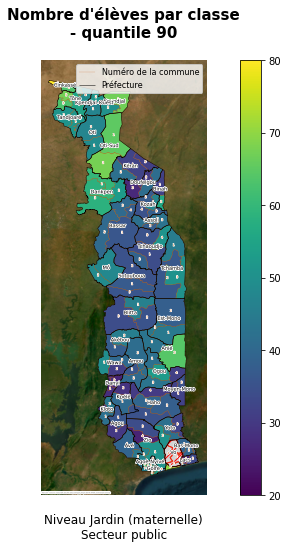

In [ ]:
## Inputs pour la carte
value_column = 'classe_percentile_90'
categorie = "Jardin (maternelle)"
title = "Nombre d'élèves par classe\n- quantile 90"

subtitle = "Niveau " + categorie + "\nSecteur public" 

cmap='viridis'  # "YlGnBu"

save_folder = os.path.join(path_save,etab_secteur,value_column)

# Créer le dossier s'il n'existe pas
os.makedirs(save_folder, exist_ok=True)

carte_save = os.path.join(save_folder, f"{categorie}_{etab_secteur}.png")


query_conditions = " commune not in ['Vo 1','Vo 2', 'Vo 3', 'Vo 4'] "
merged_stats = merged_stats.query(query_conditions)




########## Carte ##########

data_carte = merged_stats[merged_stats["etablissement_categorie"]==categorie].reset_index()

# Vérifier que les données et limites correspondent
merged = admin_boundaries.merge(data_carte, on=admin_level, how='left')

# Créer la figure
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(12, 8))#
vmin = 20
vmax = 80
merged.plot(column=value_column,cmap=cmap,ax=ax,legend=True,
            vmin=vmin, vmax=vmax, 
    missing_kwds={
        "color": "lightgrey",  # Couleur des zones sans données
        "edgecolor": "red",   # Couleur du contour
        "hatch": "//",        # Motif de hachures
        "label": "No Data"    # Légende des zones sans données
    },)#


# Tracer les limites des communes sans remplissage
communes.boundary.plot(ax=ax, edgecolor="chocolate", linewidth=0.2, label="Numéro de la commune")

# Ajouter les étiquettes des communes (numéro de communes)
communes["centroid"] = communes.geometry.centroid
for _, row in communes.iterrows():
    if not pd.isna(row["commune"]):
        ax.annotate(
            text = row["commune"][-1], # ,
            xy=(row["centroid"].x, row["centroid"].y),
            ha="center",
            fontsize=3,
            color="chocolate",
            path_effects=[
                withStroke(linewidth=1
                           , foreground="white")  # Contour blanc pour améliorer la lisibilité
            ],
        )


# Ajouter le fond de carte Google Satellite
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery,crs=merged.crs.to_string(), attribution_size=0)

# Tracer les limites des préfectures sans remplissage
prefectures.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, label="Préfecture")

# Ajouter les étiquettes des préfectures
prefectures["centroid"] = prefectures.geometry.centroid
for _, row in prefectures.iterrows():
    if not pd.isna(row["prefecture"]):
        ax.annotate(
            text=row["prefecture"],
            xy=(row["centroid"].x, row["centroid"].y),
            ha="center",
            fontsize=5,
            color="black",
            path_effects=[
                withStroke(linewidth=1.5
                           , foreground="white")  # Contour blanc pour améliorer la lisibilité
            ],
        )

# Ajouter un titre
ax.legend(loc="upper right",        # Position de la légende (relative à la carte  
    fontsize=8,              # Taille du texte de la légende
    frameon=True             # Ajouter une bordure autour de la légende
)

ax.set_title(title+"\n", fontsize=15, fontweight="bold")
ax.text(0.5, -0.1, subtitle, fontsize=12, ha="center", transform=ax.transAxes)
plt.axis('off')

fig.savefig(carte_save, dpi=300, bbox_inches="tight")
plt.show()

### Carte du nombre de salles à construire

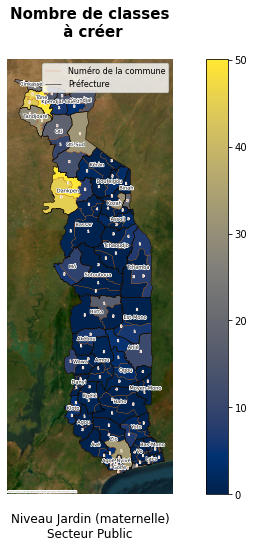

In [166]:
## Inputs pour la carte
value_column = 'classe_supplementaire'
categorie = "Jardin (maternelle)"
#title = "Nombre de salles de \nclasse à construire"
title = "Nombre de classes\n à créer"

subtitle = "Niveau " + categorie + "\nSecteur Public" 

cmap='cividis'  # ""viridis


save_folder = os.path.join(path_save,etab_secteur,value_column)
# Créer le dossier s'il n'existe pas
os.makedirs(save_folder, exist_ok=True)

carte_save = os.path.join(save_folder, f"{categorie}_{etab_secteur}_salle_supp.png")

#carte_save = os.path.join(path_save ,categorie+'_'+etab_secteur+'_salle_supp.png' )

"""
query_conditions = " commune not in ['Vo 1','Vo 2', 'Vo 3', 'Vo 4'] "
merged_stats = merged_stats.query(query_conditions)
"""



########## Carte ##########

data_carte = merged_stats[merged_stats["etablissement_categorie"]==categorie].reset_index()

# Vérifier que les données et limites correspondent
merged = admin_boundaries.merge(data_carte, on=admin_level, how='left')

# Créer la figure
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(12, 8))#
vmin = 0
vmax = np.percentile(merged[value_column].dropna(), 99)
#vmax = 180
merged.plot(column=value_column,cmap=cmap,ax=ax,legend=True,
            vmin = vmin,
            vmax = vmax,
    missing_kwds={
        "color": "lightgrey",  # Couleur des zones sans données
        "edgecolor": "red",   # Couleur du contour
        "hatch": "//",        # Motif de hachures
        "label": "No Data"    # Légende des zones sans données
    },)#


# Tracer les limites des communes sans remplissage
communes.boundary.plot(ax=ax, edgecolor="chocolate", linewidth=0.2, label="Numéro de la commune")

# Ajouter les étiquettes des communes (numéro de communes)
communes["centroid"] = communes.geometry.centroid
for _, row in communes.iterrows():
    if not pd.isna(row["commune"]):
        ax.annotate(
            text = row["commune"][-1], # ,
            xy=(row["centroid"].x, row["centroid"].y),
            ha="center",
            fontsize=3,
            color="chocolate",
            path_effects=[
                withStroke(linewidth=1
                           , foreground="white")  # Contour blanc pour améliorer la lisibilité
            ],
        )


# Ajouter le fond de carte Google Satellite
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery,crs=merged.crs.to_string(), attribution_size=0)

# Tracer les limites des préfectures sans remplissage
prefectures.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, label="Préfecture")

# Ajouter les étiquettes des préfectures
prefectures["centroid"] = prefectures.geometry.centroid
for _, row in prefectures.iterrows():
    if not pd.isna(row["prefecture"]):
        ax.annotate(
            text=row["prefecture"],
            xy=(row["centroid"].x, row["centroid"].y),
            ha="center",
            fontsize=5,
            color="black",
            path_effects=[
                withStroke(linewidth=1.5
                           , foreground="white")  # Contour blanc pour améliorer la lisibilité
            ],
        )

# Ajouter un titre
ax.legend(loc="upper right",        # Position de la légende (relative à la carte  
    fontsize=8,              # Taille du texte de la légende
    frameon=True             # Ajouter une bordure autour de la légende
)

ax.set_title(title+"\n", fontsize=15, fontweight="bold")
ax.text(0.5, -0.1, subtitle, fontsize=12, ha="center", transform=ax.transAxes)
plt.axis('off')

fig.savefig(carte_save, dpi=300, bbox_inches="tight")
plt.show()

## Analyse annexes - taux de conformité

In [ ]:
def calculer_taux_conformite(df, admin_col, categorie_col, effectif_col, normes):
    """
    Calcule le pourcentage de salles respectant les normes par admin_level et catégorie d'établissement.
    Ignore les valeurs manquantes dans categorie_col et effectif_col.
    """
    df = df.dropna(subset=[categorie_col, effectif_col])
    def est_conforme(row):
        cat = row[categorie_col]
        effectif = row[effectif_col]
        
        # Ignorer les valeurs nulles (NaN)
        if pd.isna(cat) or pd.isna(effectif):
            return np.nan  

        # Vérifier la conformité
        if cat in normes:
            min_val, max_val = normes[cat]["min"], normes[cat]["max"]
            return min_val <= effectif <= max_val
        
        return False  # Catégorie inconnue → non conforme

    # Appliquer la fonction de conformité
    df["Conforme"] = df.apply(est_conforme, axis=1)

    # Calcul du pourcentage en ignorant les NaN
    resultat = (
        df.groupby([admin_col, categorie_col])["Conforme"]
        .mean()  # Ignorer explicitement les NaN dans le calcul
        .mul(100)  # Convertir en pourcentage
        .reset_index()
        .rename(columns={"Conforme": "Pourcentage_conforme"})
    )

    # Transformer en tableau croisé
    resultat_pivot = resultat.pivot(index=admin_col, columns=categorie_col, values="Pourcentage_conforme")

    return resultat_pivot


normes = {
    "Jardin (maternelle)": {"min": 20, "max": 40},
    "Ecole primaire": {"min": 25, "max": 45},
    "College": {"min": 30, "max": 50},
    "Lycée": {"min": 35, "max": 55},
}

# Calcul du pourcentage de salles conformes par admin_level et catégorie
#resultat = calculer_taux_conformite(filtered_salle ,'region', "etablissement_categorie", "eleve_nbr_clean", normes)
resultat = calculer_taux_conformite(filtered_classe ,'region', "etablissement_categorie", "eleve_nbr", normes)

print(resultat)

resultat.to_clipboard()